## FedeNET

----

#### Goal:
Develop a custom CNN for **binary classification (flip vs notflip)** that is efficient, task-focused, and original, integrating **frequency sensitivity** directly at the input level instead of relying solely on deeper convolutional layers to capture it.

The design is inspired by the **brightness and blur analysis** (via Laplacian Variance Map) performed on the dataset, where *flip* images consistently showed higher blur and lower sharpness compared to *notflip* images.

FedeNET explicitly incorporates this insight by introducing fixed, precomputed frequency maps that help the model distinguish between motion-blurred and static frames more effectively.   


----


#### Imports and Environment

In [1]:
import random
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torchvision.transforms as tvT
import torchvision.transforms.functional as TF
from PIL import Image
import numpy as np


In [2]:
import torch, torchvision, torchaudio
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("torchaudio:", torchaudio.__version__)
print("built with CUDA:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))


torch: 2.6.0+cu124
torchvision: 0.21.0+cu124
torchaudio: 2.6.0+cu124
built with CUDA: 12.4
cuda available: True
gpu: NVIDIA GeForce GTX 1080 Ti


In [3]:
# reproducibility
SEED = 23
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# Access the datasets
DATA_ROOT = Path("data") / "images"
splits = ["training", "testing"]
classes = ["flip", "notflip"]

for split in splits:
    for cls in classes:
        p = DATA_ROOT / split / cls
        assert p.is_dir(), f"Missing folder: {p}"
print("Folder structure looks OK.")

Folder structure looks OK.


### Step 1 - Precomputed Frequency Maps

This transform:
  - converts image to grayscale
  - computes fixed, zero-parameter frequency maps:
    - 1 Sobel gradient magnitude (edges)
    - 2 Laplacian magnitude (second-order structure / blur sensitivity)
    - 3 Local variance (texture / blur sensitivity, window=7)
    - 4- High-pass (unsharp) magnitude (fine detail energy)
  - robust-normalizes each map to [0,1]
  - concatenates maps to RGB => (3 + K, H, W)


In [4]:
class AppendFrequencyMaps(torch.nn.Module):
    """
    Compute and append fixed frequency maps to an RGB image.
    Input : PIL.Image or torch.Tensor (C,H,W) in [0,1] or [0,255]
    Output: torch.Tensor (3 + K, H, W) in [0,1] per channel (robust-normalized)
    """
    def __init__(self, maps=("sobel", "laplacian", "highpass", "localvar"),
                 localvar_window=7, robust_pct=0.99):
        super().__init__()
        self.maps = tuple(maps)
        self.k = localvar_window
        self.robust_pct = robust_pct

        # Fixed 3x3 kernels (registered as buffers for device/precision moves)
        sobel_x = torch.tensor([[[-1,0,1],[-2,0,2],[-1,0,1]]], dtype=torch.float32)
        sobel_y = torch.tensor([[[-1,-2,-1],[0,0,0],[1,2,1]]], dtype=torch.float32)
        laplace = torch.tensor([[[0,1,0],[1,-4,1],[0,1,0]]], dtype=torch.float32)  # 4-neigh
        highpas = torch.tensor([[[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]], dtype=torch.float32)

        # shape (out_channels=1, in_channels=1, kH, kW)
        self.register_buffer("sobel_x", sobel_x.unsqueeze(0))
        self.register_buffer("sobel_y", sobel_y.unsqueeze(0))
        self.register_buffer("laplace", laplace.unsqueeze(0))
        self.register_buffer("highpas", highpas.unsqueeze(0))

    @staticmethod
    def _to_gray_tensor(img):
        # Accept PIL or Tensor. Output float tensor (1,H,W) in [0,1]
        if not torch.is_tensor(img):
            img = TF.to_tensor(img)  # (C,H,W) in [0,1]
        if img.ndim == 2:
            img = img.unsqueeze(0)
        if img.shape[0] == 3:
            img = TF.rgb_to_grayscale(img)
        elif img.shape[0] == 1:
            pass
        else:
            # Fallback: first channel
            img = img[:1]
        return img.clamp(0, 1)

    @staticmethod
    def _robust_norm01(x, pct=0.99, eps=1e-6):
        # Per-image robust scaling to [0,1] using (0, pct) quantiles to avoid outliers
        q_hi = torch.quantile(x.view(1, -1), torch.tensor(pct, device=x.device))
        q_lo = torch.tensor(0.0, device=x.device)  # lower clamp at 0 since magnitudes are >=0
        x = (x - q_lo).clamp(min=0.0) / (q_hi - q_lo + eps)
        return x.clamp(0, 1)

    def _local_variance(self, g1):
        # g1: (1,1,H,W) in [0,1]; window k (odd)
        k = self.k
        pad = k // 2
        w = torch.ones((1,1,k,k), device=g1.device, dtype=g1.dtype) / (k*k)
        mu  = nnF.conv2d(g1, w, padding=pad)
        mu2 = nnF.conv2d(g1*g1, w, padding=pad)
        var = (mu2 - mu*mu).clamp_min(0.0)  # numeric safety
        return var

    def forward(self, img):
        # Keep original RGB (in [0,1])
        if not torch.is_tensor(img):
            rgb = TF.to_tensor(img)  # (3,H,W) [0,1]
        else:
            rgb = img
            if rgb.dtype != torch.float32:
                rgb = rgb.float()
            if rgb.max() > 1.0:
                rgb = rgb / 255.0
            if rgb.ndim == 2:
                rgb = rgb.unsqueeze(0).repeat(3,1,1)
        rgb = rgb.clamp(0,1)

        # Gray tensor for frequency ops: (1,1,H,W)
        g = self._to_gray_tensor(rgb).unsqueeze(0)

        H, W = g.shape[-2:]
        maps_out = []

        if "sobel" in self.maps:
            gx = nnF.conv2d(g, self.sobel_x, padding=1)
            gy = nnF.conv2d(g, self.sobel_y, padding=1)
            mag = torch.sqrt(gx*gx + gy*gy)
            maps_out.append(self._robust_norm01(mag.squeeze(0), self.robust_pct))

        if "laplacian" in self.maps:
            lap = nnF.conv2d(g, self.laplace, padding=1).abs()
            maps_out.append(self._robust_norm01(lap.squeeze(0), self.robust_pct))

        if "highpass" in self.maps:
            hp = nnF.conv2d(g, self.highpas, padding=1).abs()
            maps_out.append(self._robust_norm01(hp.squeeze(0), self.robust_pct))

        if "localvar" in self.maps:
            lv = self._local_variance(g).sqrt()  # std ~ more interpretable
            maps_out.append(self._robust_norm01(lv.squeeze(0), self.robust_pct))

        if not maps_out:
            return rgb  # no-op

        freq = torch.cat(maps_out, dim=0)           # (K,H,W)
        out  = torch.cat([rgb, freq], dim=0)        # (3+K,H,W)
        return out


### 1.1 Implementing a Standalone Library and Verifying Its Classes

We will develop a dedicated **Python library** for FedeNET in parallel with this notebook.  
The goal is to organize the full implementation—model, transforms, and utilities—inside a standalone module (`FedeNet.py`) so it can be easily **imported and reused** across different notebooks or projects.  

This approach ensures cleaner experimentation here while keeping the production-ready version portable via:

In [5]:
import FedeNet  # your custom lightweight CNN
from FedeNet import AppendFrequencyMaps, ResizePad, FedeNetTiny

In [6]:
# Target size that respects the 16:9 frames but is lighter than 1080x1920
# Downscaling x2
TARGET_H, TARGET_W = FedeNet.TARGET_H, FedeNet.TARGET_W  # 540, 960
# From ImageNet
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

In [7]:
# Example integration
# Choose the maps to include:
FREQ_CHANNELS = ("sobel", "laplacian", "localvar", "highpass")

# IMPORTANT: If normalize with ImageNet stats, only apply them to the first 3 channels.
# For the extra frequency channels, either:
#   (A) skip normalization, since they’re already in [0,1], or
#   (B) normalize with mean=0.5, std=0.5 (simple affine to [-1,1]).
# Below, we show (A) for clarity; swap for (B) if desired.

train_tfms_fede = tvT.Compose([
    FedeNet.ResizePad(TARGET_H, TARGET_W, fill=0),
    tvT.RandomRotation(degrees=5, fill=0),
    tvT.ColorJitter(brightness=0.1, contrast=0.1),
    # Append frequency maps (now tensor):
    AppendFrequencyMaps(maps=FREQ_CHANNELS),
    # Split: normalize RGB only
    #   -> implement a small lambda to normalize first 3 channels
    tvT.Lambda(lambda x: torch.cat([
        tvT.Normalize(IMAGENET_MEAN, IMAGENET_STD)(x[:3]),
        x[3:]  # leave frequency channels as-is (0..1)
    ], dim=0)),
])

In [8]:
val_tfms_fede = tvT.Compose([
    FedeNet.ResizePad(TARGET_H, TARGET_W, fill=0),
    AppendFrequencyMaps(maps=FREQ_CHANNELS),
    tvT.Lambda(lambda x: torch.cat([
        tvT.Normalize(IMAGENET_MEAN, IMAGENET_STD)(x[:3]),
        x[3:]
    ], dim=0)),
])


In [9]:
import matplotlib.pyplot as plt

In [10]:
def _denorm_rgb(rgb3, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """rgb3: (3,H,W) tensor, denorm to [0,1] for display."""
    m = torch.tensor(mean, dtype=rgb3.dtype, device=rgb3.device).view(3,1,1)
    s = torch.tensor(std,  dtype=rgb3.dtype, device=rgb3.device).view(3,1,1)
    x = rgb3 * s + m
    return x.clamp(0, 1)

def visualize_fede_two_rows(x, freq_names=("Sobel","Laplacian","LocalVar","HighPass"),
                            figsize=(16, 8)):
    """
    x: tensor (3+K, H, W) produced *after* AppendFrequencyMaps and (optionally) RGB normalization.
    Shows:
        Row 1: Composite RGB, R, G, B (channel planes)
        Row 2: 4 frequency maps in order they appear after RGB (x[3:], first 4)
    """
    assert x.ndim == 3 and x.shape[0] >= 7, "Expected (>=7, H, W) with 3 RGB + 4 freq maps."

    # RGB composite (denormalize first 3 only)
    rgb = _denorm_rgb(x[:3].clone())
    R, G, B = rgb[0:1], rgb[1:2], rgb[2:3]  # for grayscale display of planes

    # Frequency maps (already 0..1 from our transform)
    fmaps = x[3:7].detach()  # take the first 4 freq channels in the given order

    titles_row1 = ["Composite", "R", "G", "B"]
    titles_row2 = list(freq_names)[:4]

    fig, axes = plt.subplots(2, 4, figsize=figsize)

    # Row 1
    axes[0,0].imshow(rgb.permute(1,2,0).cpu().numpy())
    axes[0,0].set_title(titles_row1[0]); axes[0,0].axis('off')

    for i, ch in enumerate([R, G, B], start=1):
        axes[0,i].imshow(ch.squeeze(0).cpu().numpy(), cmap='gray')
        axes[0,i].set_title(titles_row1[i]); axes[0,i].axis('off')

    # Row 2
    for j in range(4):
        axes[1,j].imshow(fmaps[j].cpu().numpy(), cmap='gray')
        axes[1,j].set_title(titles_row2[j]); axes[1,j].axis('off')

    plt.tight_layout()
    plt.show()


### 1.2 Visualization Test

In [11]:
import pandas as pd
from torchvision.io import read_image
from PIL import ImageOps

In [12]:
# open the csv with the image dataset metadata
extraction_table_file = "all_images.csv"
df = pd.read_csv(DATA_ROOT / extraction_table_file)
df.head()

,Unnamed: 0,path,split,label,w,h,mode,ratio
0,0,data\images\training\flip\0001_000000010.jpg,training,flip,1080,1920,RGB,0.5625
1,1,data\images\training\flip\0001_000000011.jpg,training,flip,1080,1920,RGB,0.5625
2,2,data\images\training\flip\0001_000000012.jpg,training,flip,1080,1920,RGB,0.5625
3,3,data\images\training\flip\0001_000000013.jpg,training,flip,1080,1920,RGB,0.5625
4,4,data\images\training\flip\0001_000000014.jpg,training,flip,1080,1920,RGB,0.5625


In [13]:
flip_rows = df[df['label'] == 'flip']
notflip_rows = df[df['label'] == 'notflip']

# flip image (moving)
flip_image_path = flip_rows.sample(n=1, random_state=SEED)
flip_image_path = flip_image_path['path'].iloc[0]
flip_tensor = read_image(flip_image_path)

# notflip image (static)
notflip_image_path = notflip_rows.sample(n=1, random_state=SEED)
notflip_image_path = notflip_image_path['path'].iloc[0]
notflip_tensor = read_image(notflip_image_path)

In [14]:
flip_image_path, notflip_image_path

('data\\images\\training\\flip\\0061_000000021.jpg',
 'data\\images\\testing\\notflip\\0004_000000029.jpg')

In [15]:
# Choose which pipeline to show
FEDE_TFM = val_tfms_fede   # or train_tfms_fede to see jitter/rotation too

In [16]:
# Build a minimal pipeline that matches your val_tfms_fede (no DA here)
val_tfms_fede_vis = tvT.Compose([
    FedeNet.ResizePad(TARGET_H, TARGET_W, fill=0),
    AppendFrequencyMaps(maps=("sobel","laplacian","localvar","highpass")),
    tvT.Lambda(lambda x: torch.cat([
        tvT.Normalize(IMAGENET_MEAN, IMAGENET_STD)(x[:3]),
        x[3:]
    ], dim=0)),
])

Flip: data\images\training\flip\0061_000000021.jpg


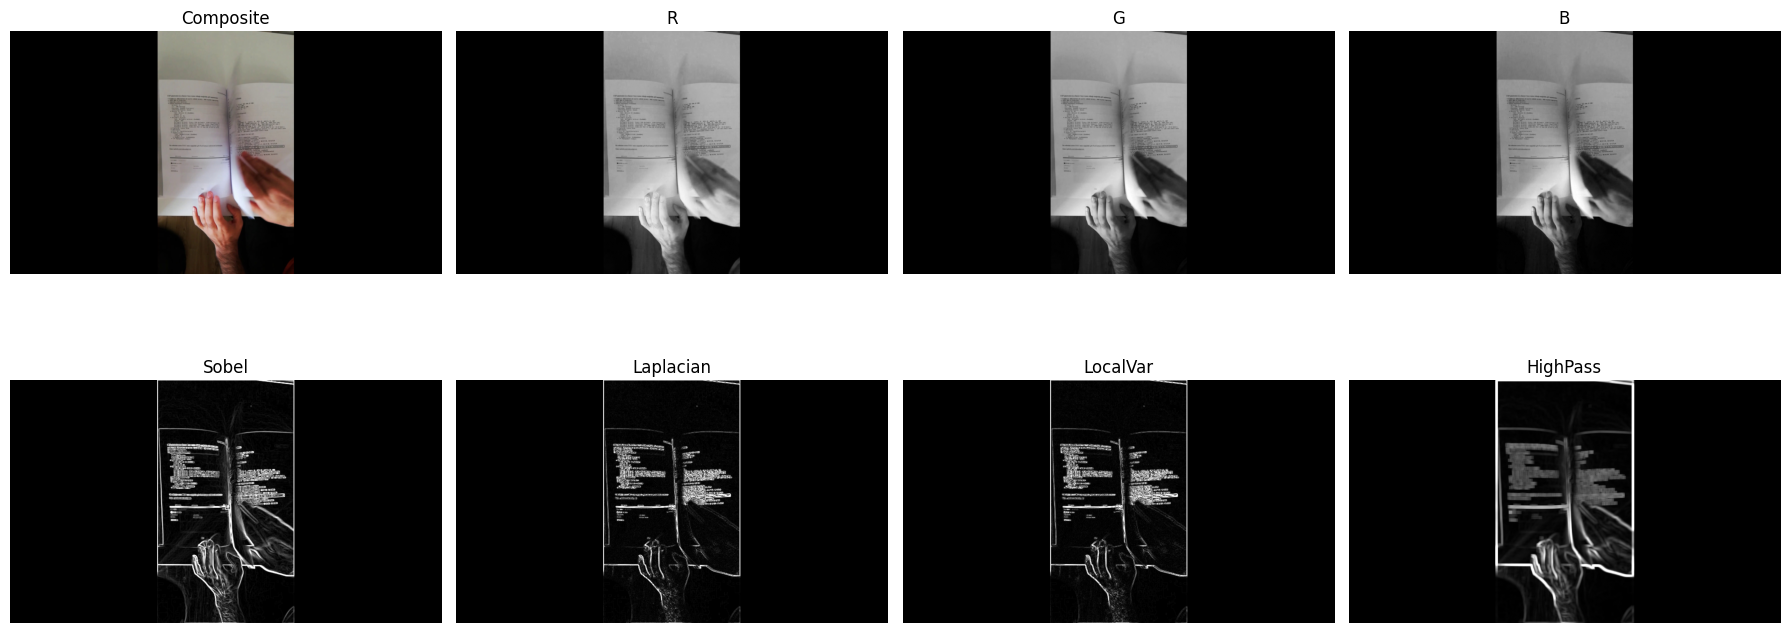

Notflip: data\images\testing\notflip\0004_000000029.jpg


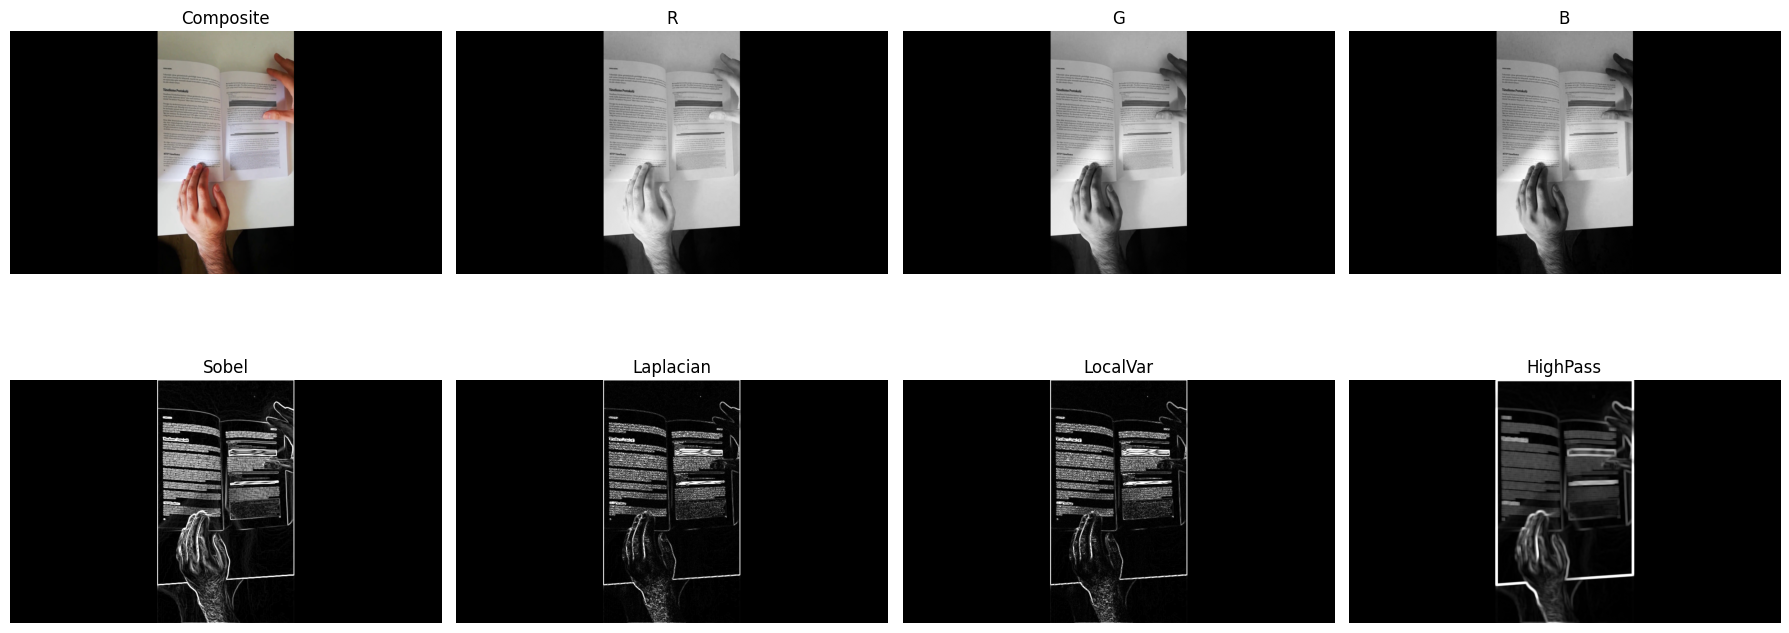

In [17]:
# Load paths from the df
flip_img = Image.open(flip_image_path).convert("RGB")
notflip_img = Image.open(notflip_image_path).convert("RGB")

flip_x = val_tfms_fede_vis(flip_img)      # (7, H, W)
notflip_x = val_tfms_fede_vis(notflip_img)

print("Flip:", flip_image_path)
visualize_fede_two_rows(flip_x, figsize=(18, 8))

print("Notflip:", notflip_image_path)
visualize_fede_two_rows(notflip_x, figsize=(18, 8))

In [18]:
flip_x.shape

torch.Size([7, 540, 960])

### Frequency-Channel Visualization: Key Findings

**Setup:** RGB frames + four fixed maps (Sobel, Laplacian, LocalVar, HighPass), after `ResizePad` (centered, aspect-preserving).

**Observations**
- **RGB (Composite, R/G/B):** Clean, centered inputs.
- **Sobel (∥∇I∥):** Flip frames show denser, elongated edge responses (motion streaks). Notflip frames show sharper, localized edges.
- **Laplacian (∇²I):** Flip frames exhibit weaker, grainy responses. Notflip frames display crisp line emphasis.
- **Local Variance (k=7):** Flip frames are darker (lower local texture energy = blur). Notflip frames are brighter around text and borders.
- **HighPass (unsharp magnitude):** Flip suppresses fine detail. Notflip preserves high-frequency content across the page.

**Conclusion**
- Motion blur produces **systematic, separable signatures** across all frequency maps.
- **LocalVar + HighPass** act as explicit sharpness/texture indicators. **Sobel + Laplacian** reinforce edge quality differences.
- These channels provide **task-relevant cues** that a standard CNN would otherwise have to infer, justifying their inclusion for FedeNET.


----

### Step 2 - Testing FedeNet Library Implementation

We’ll now verify that the library-defined components (StemAA, SpatialStream, FrequencyStream, and Head) integrate correctly inside the FedeNetTiny architecture.
 
This test will:
1. Instantiate the model.
2. Pass a dummy input tensor shaped like a preprocessed image batch (7×540×960).
3. Check parameter count and output dimensions.
4. Confirm the model runs forward without shape mismatches.

In [19]:
from torchsummary import summary  # optional (pip install torchsummary if missing)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [21]:
# Instantiate model: 7 input channels (RGB + 4 freq maps)
model = FedeNet.FedeNetTiny(in_ch=7).to(device)
model.eval();


In [22]:
# Now create a dummy batch ON THE SAME DEVICE
x = torch.randn(2, 7, FedeNet.TARGET_H, FedeNet.TARGET_W, device=device)

with torch.no_grad():
    y = model(x)

print("Output shape:", y.shape)
print("Sample logits:", y[:5])

Output shape: torch.Size([2, 1])
Sample logits: tensor([[-0.6334],
        [-0.6268]], device='cuda:0')


In [23]:
from torchinfo import summary

In [24]:
# Use the real input size (B can be 1 for summary)
stats = summary(model, input_size=(1, 7, 540, 960), verbose=1, 
            col_names=("input_size", "output_size", "num_params", "kernel_size", "mult_adds")
        )

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
FedeNetTiny                                   [1, 7, 540, 960]          [1, 1]                    --                        --                        --
├─StemAA: 1-1                                 [1, 7, 540, 960]          [1, 32, 270, 480]         --                        --                        --
│    └─Conv2d: 2-1                            [1, 7, 540, 960]          [1, 32, 540, 960]         2,016                     [3, 3]                    1,045,094,400
│    └─BatchNorm2d: 2-2                       [1, 32, 540, 960]         [1, 32, 540, 960]         64                        --                        64
│    └─SiLU: 2-3                              [1, 32, 540, 960]         [1, 32, 540, 960]         --                        --                        --
│    └─BlurPool2d: 2-4                        [1, 32, 540, 960] 

### 2.1 

In [27]:
from FedeNet import load_rgb_pretrained_into_fedenet

In [28]:
# ---- Usage ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FedeNet.FedeNetTiny(in_ch=7).to(device)


In [29]:
# Copy RGB pretrained from EfficientNet-B0 (best shape match: 3→32, k=3)
load_rgb_pretrained_into_fedenet(model, backbone="efficientnet_b0", device=device)


[HybridInit] Loaded RGB weights from efficientnet_b0 → FedeNet stem.
[HybridInit] Stem conv weight shape now: torch.Size([32, 7, 3, 3]) (expects 7 input chans).


In [30]:
# Ready to fine-tune on flip/notflip
model.eval()
x = torch.randn(2, 7, FedeNet.TARGET_H, FedeNet.TARGET_W, device=device)
with torch.no_grad():
    y = model(x)
print("Sanity forward OK. Output:", y.shape)



Sanity forward OK. Output: torch.Size([2, 1])
